# **Simulation Assignment \#2: EE4140 Digital Communication Systems**

**Name:** Akash Reddy A <br>
**Roll Number:** EE17B001

## **(a) Viterbi Algorithm**

In [20]:
# Importing required packages

import numpy as np
import matplotlib.pyplot as plt

In [21]:
# The value of d for the 4PAM constellation is calculated using the given 
# value of signal power
d = 1/np.sqrt(5)

# Generation of the 100,002 symbols of I(k)

Ik = np.random.uniform(size=100002)
Ik[Ik<=0.25] = -3*d
Ik[(0.25<Ik) & (Ik<=0.5)] = -d
Ik[(0.5<Ik) & (Ik<=0.75)] = d
Ik[(0.75<Ik) & (Ik<=1)] = 3*d

In [22]:
# Channel coefficients
f0 = 0.8/np.sqrt(2)
f1 = -1/np.sqrt(2)
f2 = 0.6/np.sqrt(2)
f = np.array([f0, f1, f2])

M = 4       # Size of the alphabet (4PAM)
L = 3       # Size of the channel

# Array of possible symbols for 4PAM
symbols = [-3*d, -d, d, 3*d]

# The M^(L-1) = 4^2 = 16 possible states are mapped to keys 0-15
state_encodes = {0:(-3*d, -3*d), 1:(-d, -3*d), 2:(d, -3*d), 3:(3*d, -3*d),
                     4:(-3*d, -d), 5:(-d, -d), 6:(d, -d), 7:(3*d, -d),
                     8:(-3*d, d), 9:(-d, d), 10:(d, d), 11:(3*d, d),
                     12:(-3*d, 3*d), 13:(-d, 3*d), 14:(d, 3*d), 15:(3*d, 3*d)}


# Function to get the key of a value from a dictionary (for convenience)
def get_key(dic, val):
    for key, value in dic.items():
         if val == value:
             return key

# Dictionary of state-symbol tuples mapping to next states
next_states = {}
for i in state_encodes:
    for j in symbols:
        next_states[(i, j)] = get_key(state_encodes, (j, state_encodes[i][0]))


# Function to pick the symbol that leads from one state to a next state
def symbol_picker(k, k_next):
    for symb in symbols:
        if next_states[(k, symb)] == k_next:
            return symb

# Function to perform the Viterbi Algorithm
def viterbiEst(SNR, Ik, delta):
    var_I = 1               # Signal variance
    var_v = var_I/SNR       # Noise variance

    # 2d array to store the Cumulative Metric of trellis at each stage of VA
    # Initialised at -1 instead of 0, to allow for 0 CM to be recognizable
    CM = np.ones((M**(L-1), len(Ik)-2+1))*-1

    # 2d array- stores survivor predecessor state of each state at current stage
    # This array can then be used to trace back the survivor sequence
    survivor_seq = np.ones((M**(L-1), len(Ik)-2+1))*-1
    
    # The channel values are initialised
    channel = np.ones(L)*-1*d

    # The initial state key is obtained
    state = get_key(state_encodes, tuple(channel[:-1]))
    states_visited = [state]

    # Stores decoded sequence
    decoded_seq = []

    # Iteration through input sequence except the "tail symbols"
    for ind, i in enumerate(Ik[:-2]):

        # Start decoding delayed symbols if the decoding delay has elapsed
        # from the initial time
        if ind >= delta:
            k = int(survivor_seq[np.argmin(CM[:,ind]), ind])
            k_next = k

            # Loop to step back into trellis until we reach delta steps back
            for back_step in range(1, delta):
                k_next = k
                k = int(survivor_seq[k, ind-back_step])

            # Decode the delayed symbol and add it to sequence
            decoded_symbol = symbol_picker(k, k_next)
            decoded_seq.append(decoded_symbol)

        # Pushing the symbol I(k) into channel
        for j in range(L-1,0,-1):
            channel[j] = channel[j-1]
        channel[0] = i

        # Calculation of r(k) by convolution + adding noise
        yk = np.dot(f, channel)
        vk = np.random.normal()*np.sqrt(var_v)
        rk = yk + vk

        # Dictionary to store the survivor predecessor states of current stage
        survivor_states = {}

        # List to store all the next states visited from the current stage
        visits = []

        # Iterating through all next-states visited in the previous iteration
        """(In the first few iterations, the trellis spreads out from size 1 to 
        maximum size. This is why it is necessary to keep a record of next 
        states visited, so that we know how exactly to branch.)"""
        for state in states_visited:
            r_est = []

            for symbol in symbols:
                r_esti = np.dot(f, [symbol]+list(state_encodes[state]))
                r_est.append(r_esti)
                # Calculating Transition Metric for each symbol
                TM = (rk - r_esti)**2

                next_state = next_states[(state, symbol)]

                # If next state has already been visited, replace its CM only 
                # if lesser than already existing CM at this next state.
                # This is how we select survivor states.
                if next_state in visits:
                    if CM[state, ind] + TM < CM[next_state, ind+1]:
                        CM[next_state, ind+1] = CM[state, ind] + TM
                        survivor_states[next_state] = state

                # If next state has not been visited yet, necessarily update CM.
                else:
                    CM[next_state, ind+1] = CM[state, ind] + TM
                    survivor_states[next_state] = state
                visits.append(next_state)
            
        # Update the survivor states of current stage in the corresponding
        # column of the 2d array
        for st in survivor_states:
            survivor_seq[st, ind+1] = survivor_states[st]
                
        # If a state has been visited, include it in the set of visited states
        # for next iteration.
        states_visited = set(visits)

    """At the end of the delayed decoding, when we reach the end of the sequence,
    the last 'delta' symbols of I(k) have not been decoded. Therefore, we now
    decode them and append them to the decoded sequence."""

    last_bits = []

    # Decode very last bit
    k = int(survivor_seq[np.argmin(CM[:,-1]), -1])
    k_next = k
    last_bits.append(symbol_picker(k, np.argmin(CM[:,-1])))

    # Decode the rest of the last 'delta' bits
    for back_step in range(1, delta):
        k_next = k
        k = int(survivor_seq[k, -1-back_step])
        last_bits.append(symbol_picker(k, k_next))
    
    # Appending to decoded sequence
    decoded_seq += reversed(last_bits)

    return decoded_seq 

In [23]:
# SNR values s.t. 10log(SNR) = 0, 2, 4, 6, 8, 10, 12, 14, 16 dB as required
SNR_list = np.logspace(0, 1.6, 9, base = 10)
dB_SNR = 10*np.log10(SNR_list)      # Converted to dB

deltas = [3, 6, 15, 30]

SER_lists = {}

# Running Viterbi Algorithm for all required values of 'delta'
# Across the range of SNR required

for dlta in deltas:
    print("Running for delta = ", dlta)
    log_SER_list = []
    for snr in SNR_list:
        decoded_seq = viterbiEst(SNR = snr, Ik=Ik, delta = dlta)

        # Calculation of SER = 1 - fraction of matched symbols
        SER = 1 - np.sum(Ik[:-2] == decoded_seq)/len(Ik[:-2])

        log_SER = np.log10(SER)
        log_SER_list.append(log_SER)
        print("SNR =", 10*np.log10(snr), " dB done...")

    # Storing the list of log_10SER values corresponding to each delta
    # in a dictionary for plotting
    SER_lists[dlta] = log_SER_list

Running for delta =  3
SNR = 0.0  dB done...
SNR = 2.0000000000000004  dB done...
SNR = 4.0  dB done...
SNR = 6.000000000000001  dB done...
SNR = 8.0  dB done...
SNR = 10.0  dB done...
SNR = 12.000000000000002  dB done...
SNR = 14.000000000000002  dB done...
SNR = 16.0  dB done...
Running for delta =  6
SNR = 0.0  dB done...
SNR = 2.0000000000000004  dB done...
SNR = 4.0  dB done...
SNR = 6.000000000000001  dB done...
SNR = 8.0  dB done...
SNR = 10.0  dB done...
SNR = 12.000000000000002  dB done...
SNR = 14.000000000000002  dB done...
SNR = 16.0  dB done...
Running for delta =  15
SNR = 0.0  dB done...
SNR = 2.0000000000000004  dB done...
SNR = 4.0  dB done...
SNR = 6.000000000000001  dB done...
SNR = 8.0  dB done...
SNR = 10.0  dB done...
SNR = 12.000000000000002  dB done...
SNR = 14.000000000000002  dB done...
SNR = 16.0  dB done...
Running for delta =  30
SNR = 0.0  dB done...
SNR = 2.0000000000000004  dB done...
SNR = 4.0  dB done...
SNR = 6.000000000000001  dB done...
SNR = 8.0  d

<br><br><br><br><br><br><br><br><br>
   

    
     
      
       
        
         


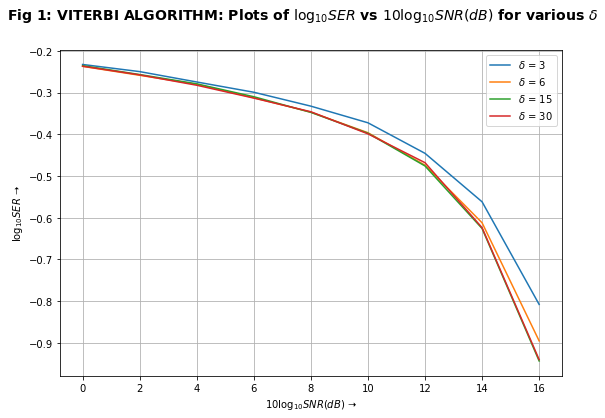

In [122]:
# Plotting the log_10SER vs 10log_10SNR for Viterbi Algorithm

fig, ax = plt.subplots(figsize=(9,6))
for dlta in deltas:
    ax.plot(dB_SNR, SER_lists[dlta], label = f"$\delta$ = {dlta}")
ax.legend()
ax.grid(True)
plt.suptitle("Fig 1: VITERBI ALGORITHM: Plots of $\log_{10}SER$ vs $10\log_{10}SNR (dB)$ for various $\delta$", fontsize = 14, fontweight = "bold")
ax.set_xlabel("$10\log_{10}SNR (dB)$ \u279d")
ax.set_ylabel("$\log_{10}SER$ \u279d")
plt.show()

- The performance improves quite rapidly (lower SER) as we increase SNR (magnitude of slope increasing even in the logarithmic scale).
- We observe that the overall performance of the Viterbi Algorithm first improves (lower SER across many values of SNR) with increasing $\delta$, until it a reaches a value of roughly $5L$ (here $L=3$, so $5L = 15$). The performance then decreases once again as we go on increasing $\delta$ value. **Therefore, there is an optimal range of decoding delay ($\delta$) values** that gives us the best results of the Viterbi algorithm.
- This is visible from the fact that the $\delta = 30$ curve is slightly above (higher SNR than) then $\delta = 15$ curve.


___________________________________________________________

## **(b) Linear Equalizer**

The Wiener solution to the Linear Equalizer is given by:
\begin{align}
\mathbf{w_{opt}} & = \mathbf{R}^{-1}\cdot\mathbf{p}
\end{align} 
<br>
The matrix $\mathbf{R}$ is calculated as follows:
\begin{align}
\mathbf{R} & = \mathbb{E}[\mathbf{r\cdot r^T}]
\end{align}
where the vector $\mathbf{r}$ is given by
\begin{align}
\mathbf{r}=
\begin{bmatrix}
r(k) & r(k-1) & \ldots & r(k-N+1)
\end{bmatrix}^T
\end{align}
where $N = $ order of the Linear Equalizer.

Therefore, 
\begin{align}
\mathbf{R} & = \mathbb{E}
\begin{bmatrix}
r(k)r(k) & r(k)r(k-1) & \ldots & r(k)r(k-N+1) \\
r(k-1)r(k) & r(k-1)r(k-1) & \ldots & r(k-1)r(k-N+1) \\
\vdots & \vdots & \ldots & \vdots \\
r(k-N+1)r(k) & r(k-N+1)r(k-1) & \ldots & r(k-N+1)r(k-N+1) \\
\end{bmatrix}
\end{align} 

<br>
Considering that, for an $L=3$ channel,

\begin{align}
r(k) &= f_0\cdot I(k) + f_1\cdot I(k-1) + f_2\cdot I(k-2) + v(k)\\
r(k-1) &= f_0\cdot I(k-1) + f_1\cdot I(k-2) + f_2\cdot I(k-3)  + v(k)\\
&\vdots \\
r(k-N+1) &= f_0\cdot I(k-N+1) + f_1\cdot I(k-N) + f_2\cdot I(k-N-1) + v(k)\\
\end{align}

and assuming that the $v(k)$ and $I(k)$ are uncorrelated, we have:
\begin{align}
\mathbb{E}[r(k)r(k)] = (f_0^2+f_1^2+f_2^2)\sigma_I^2 + \sigma_v^2
\end{align}
taking only the terms that are correlated. <br>
Similarly,
\begin{align}
    \mathbb{E}[r(k)r(k-1)] &= (f_0f_1 + f_1f_2)\sigma_I^2 \\
    \mathbb{E}[r(k)r(k-2)] &= f_0f_2\sigma_I^2
\end{align}

In this manner, we can write the $\mathbf{R}$ matrix for the $L=3$ channel.
\begin{align}
\mathbf{R} & =
\begin{bmatrix}
(f_0^2+f_1^2+f_2^2)\sigma_I^2 + \sigma_v^2 & (f_0f_1 + f_1f_2)\sigma_I^2 & \ldots & 0 \\
(f_0f_1 + f_1f_2)\sigma_I^2 & (f_0^2+f_1^2+f_2^2)\sigma_I^2 + \sigma_v^2 & \ldots & 0\\
\vdots & \vdots & \ldots & \vdots \\
0 &(f_0f_1 + f_1f_2)\sigma_I^2 & \ldots & (f_0^2+f_1^2+f_2^2)\sigma_I^2 + \sigma_v^2 \\
\end{bmatrix}
\end{align}
which is Toeplitz in nature.
<br><br>

The vector $\mathbf{p}$ is calculated as follows:
\begin{align}
\mathbf{p} & = \mathbb{E}[\mathbf{r} \cdot I(k-\Delta)]
\end{align}
where $\Delta$ is the decoding delay.

Suppose $\Delta = 0$. Then the vector $\mathbf{p}$ is given by
\begin{align}
\mathbf{p} & = \mathbb{E}[\mathbf{r} \cdot I(k)]\\
& = \begin{bmatrix}
f_0 & 0 & 0 & \ldots & 0
\end{bmatrix}^T
\end{align}

If $\Delta = 1$, we have
\begin{align}
\mathbf{p} & = \mathbb{E}[\mathbf{r} \cdot I(k-1)]\\
& = \begin{bmatrix}
f_1 & f_0 & 0 & \ldots & 0
\end{bmatrix}^T
\end{align}

If $\Delta = 2$, we have
\begin{align}
\mathbf{p} & = \mathbb{E}[\mathbf{r} \cdot I(k-2)]\\
& = \begin{bmatrix}
f_2 & f_1 & f_0 & \ldots & 0
\end{bmatrix}^T
\end{align}
and so on.

__________________________________________________________

The minimum cost $J_{min}$ of the Wiener solution is given by 
\begin{align}
J_{min} & = \sigma_I^2 + \mathbf{w_{opt}}^T\cdot \mathbf{p}
\end{align}

__________________________________________________________

The Linear Equalizer is implemented in code below.

In [66]:
# Importing required packages

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.linalg import toeplitz

In [67]:
# Channel Coefficients

f0 = 0.8/np.sqrt(2)
f1 = -1/np.sqrt(2)
f2 = 0.6/np.sqrt(2)
f = np.array([f0, f1, f2])

# Function to evaluate Wiener Solution for Linear Equalizer
def linearEq(SNR, L, N, delta):
    var_I = 1           # Signal variance
    var_v = 1/SNR       # Noise variance
    
    R_col = []
    p = []

    # Generating R and p in a clever manner, using the channel coefficients
    # and signal and noise variances
    for j in range(N):
        R_col.append(np.matmul(np.hstack((f, np.zeros(j))), 
                               np.hstack((np.zeros(j), f)).T)*var_I)
        if delta-j in range(0, L):
            p.append(f[delta-j]*var_I)
        else:
            p.append(0)

    R = toeplitz(R_col) + np.eye(N)*var_v
    p = np.array(p)[:, np.newaxis]

    # Using R*w_opt = p to evaluate w_opt
    w_opt = np.matmul(np.linalg.inv(R), p).flatten()

    # Using var_I - w_opt.T*p to evaluate J_min (minimum cost)
    J_min = var_I - np.matmul(w_opt.T, p).flatten()[0]

    return w_opt, J_min

### (b1)

In [68]:
w_opt1, J_min1 = linearEq(SNR = 10, L = 3, N = 3, delta = 0)
print(f"Wiener Solution (N=3, Delta=0) is")
print(f"w_opt = {w_opt1},")
print(f"J_min = {J_min1}")

Wiener Solution (N=3, Delta=0) is
w_opt = [0.959 0.802 0.301],
J_min = 0.4576781847283682


### (b2)

In [69]:
w_opt2, J_min2 = linearEq(SNR = 10, L = 3, N = 10, delta = 0)
print(f"Wiener Solution (N=10, Delta=0) is")
print(f"w_opt = {w_opt2},")
print(f"J_min = {J_min2}")

Wiener Solution (N=10, Delta=0) is
w_opt = [ 0.982  0.842  0.313 -0.082 -0.2   -0.137 -0.034  0.027  0.035  0.016],
J_min = 0.44470802028801537


### (b3)

In [70]:
w_opt3, J_min3 = linearEq(SNR = 10, L = 3, N = 10, delta = 5)
print(f"Wiener Solution (N=10, Delta=5) is")
print(f"w_opt = {w_opt3},")
print(f"J_min = {J_min3}")

Wiener Solution (N=10, Delta=5) is
w_opt = [ 0.052  0.183  0.295  0.175 -0.361  0.589  0.644  0.305  0.019 -0.054],
J_min = 0.33687413740034433


### (b4)

N = 3, delta = 0, J = 0.4576781847283682
N = 5, delta = 0, J = 0.4515786144844809
N = 8, delta = 0, J = 0.4451165482716586
N = 10, delta = 0, J = 0.44470802028801537
N = 15, delta = 0, J = 0.4446745680019779
N = 20, delta = 0, J = 0.44467388130205254
N = 30, delta = 0, J = 0.4446738681171505
N = 40, delta = 0, J = 0.44467386811563303



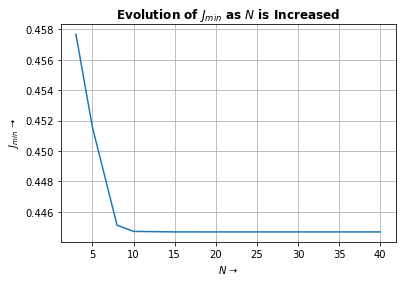


(Nearly) Best value of N = 20


In [71]:
# Searching through ranges of N and Delta through trial-and-error

# Selecting best value of N

N_list_LE = [3, 5, 8, 10, 15, 20, 30, 40]

J_list_LE = []
for N_val in N_list_LE:
    _, J = linearEq(SNR = 10, L = 3, N = N_val, delta = 0)
    print(f"N = {N_val}, delta = 0, J =", J)
    J_list_LE.append(J)

"""J_min keeps reducing as N increases.
Since it does not reduce much after N = 15, keeping in mind practical
limitations, N = 20 is selected"""

print()
plt.figure(figsize=(6,4))
plt.plot(N_list_LE, J_list_LE)
plt.xlabel("$N$ \u279d")
plt.ylabel("$J_{min}$ \u279d")
plt.title("Evolution of $J_{min}$ as $N$ is Increased", fontweight = 'bold')
plt.grid(True)
plt.show()

selected_N_LE = 20
print()
print("(Nearly) Best value of N =", selected_N_LE)

N = 20, delta = 0, J = 0.44467388130205254
N = 20, delta = 1, J = 0.35916297774253225
N = 20, delta = 2, J = 0.3591579158894824
N = 20, delta = 3, J = 0.3447910169179218
N = 20, delta = 4, J = 0.33403120040266565
N = 20, delta = 5, J = 0.33250740904379616
N = 20, delta = 6, J = 0.3324131161157666
N = 20, delta = 7, J = 0.3318108781295974
N = 20, delta = 8, J = 0.3315251255536009
N = 20, delta = 9, J = 0.3315061922677629
N = 20, delta = 10, J = 0.33151404589331146
N = 20, delta = 11, J = 0.3315926190616154
N = 20, delta = 12, J = 0.33168907885993104
N = 20, delta = 13, J = 0.3316988880877486
N = 20, delta = 14, J = 0.3326524343066901
N = 20, delta = 15, J = 0.33579356492917445
N = 20, delta = 16, J = 0.3374947186848849
N = 20, delta = 17, J = 0.33995989933490134
N = 20, delta = 18, J = 0.3804684140293082
N = 20, delta = 19, J = 0.46761949371363853



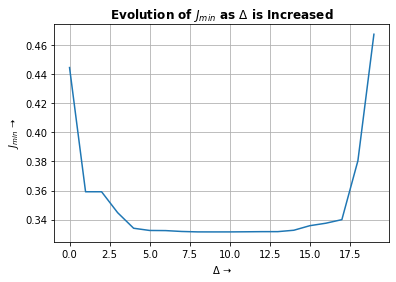


Best value of delta = 9 with a final best J_min value of 0.3315061922677629


In [72]:
# Selecting best value of 'delta' and finfing best J_min
selected_N_LE = 20
delta_list_LE = list(range(selected_N_LE))

J_list_LE = []

for delta_val in delta_list_LE:
    _, J = linearEq(SNR = 10, L = 3, N = selected_N_LE, delta = delta_val)
    print(f"N = 20, delta = {delta_val}, J =", J)
    J_list_LE.append(J)

print()
plt.figure(figsize=(6,4))
plt.plot(delta_list_LE, J_list_LE)
plt.xlabel("$\Delta$ \u279d")
plt.ylabel("$J_{min}$ \u279d")
plt.title("Evolution of $J_{min}$ as $\Delta$ is Increased", fontweight = 'bold')
plt.grid(True)
plt.show()

selected_delta_LE = delta_list_LE[np.argmin(J_list_LE)]
print()
print("Best value of delta =", selected_delta_LE, 
      "with a final best J_min value of", min(J_list_LE))

- We observe clearly from the plot that there is an optimal range of $\Delta$ for least cost and best performance.

In [73]:
# Storing best N, delta, and calculating best w_opt

N_best_LE = selected_N_LE
delta_best_LE = selected_delta_LE

w_opt_best_LE, J_min_best_LE = linearEq(SNR = 10, L = 3, N = N_best_LE, 
                                        delta = delta_best_LE)

# Printing best N, Delta, J_min

print("Final best values of N, Delta, J_min:")
print("N1 =", N_best_LE)
print("Delta =", delta_best_LE)
print("J_min =", J_min_best_LE)

Final best values of N, Delta, J_min:
N1 = 20
Delta = 9
J_min = 0.3315061922677629


### (b5)

In [74]:
# Simulating the Linear Equalizer to measure and plot SER

def simulateLE(SNR, Ik, N, delta):
    var_I = 1           # Signal variance
    var_v = var_I/SNR   # Noise variance

    L = 3           # Channel length

    # Calculating the w_opt and J_min using given N and delta values
    w_, J_ = linearEq(SNR = SNR, L = 3, N = N, delta = delta)

    # Initialising channel and equalizer values
    channel = np.ones(L)*-1*d
    w_vals = np.ones(len(w_))*-1*d

    # Stores decoded sequence
    decoded_seq = []

    # Iterating through symbols of input sequence except the "tail symbols"
    for ind, i in enumerate(Ik[:-2]):
        # Pushing symbol into channel
        for j in range(L-1,0,-1):
            channel[j] = channel[j-1]
        channel[0] = i

        # Calculating the r(k)
        yk = np.matmul(f, channel.T)
        vk = np.random.normal()*np.sqrt(var_v)
        rk = yk + vk

        # Pushing r(k) into the equalizer
        for j in range(len(w_vals)-1, 0, -1):
            w_vals[j] = w_vals[j-1]
        w_vals[0] = rk

        # Calculating the equalizer output
        eq_op = np.matmul(w_, w_vals.T)

        # Symbol prediction - picking least distant symbol
        pred_symb = 0
        if eq_op < -2*d:
            pred_symb = -3*d
        elif eq_op < 0:
            pred_symb = -d
        elif eq_op < 2*d:
            pred_symb = d
        else:
            pred_symb = 3*d
        
        # Appending decoded symbol to sequence
        decoded_seq.append(pred_symb)

        """We need to discard last 'delta' symbols of I(k) as they are not 
        convolved properly, and the first 'delta' symbols of decoded sequence, 
        since they are junk values."""
        # Discarding the last delta values of I(k) if delta > 0
        if delta == 0:
            Ik_valid = Ik[:-2]
        else:
            Ik_valid = Ik[:-2][:-delta]

    return Ik_valid, decoded_seq[delta:]


In [75]:
# SNR values s.t. 10log(SNR) = 0, 2, 4, 6, 8, 10, 12, 14, 16 dB as required
SNR_list = np.logspace(0, 1.6, 9, base = 10)
dB_SNR = 10*np.log10(SNR_list)

# Evaluating SER and storing in a list for plotting
log_SER_list_LE = []
for snr in SNR_list:
    Ik_valid, decoded_seq = simulateLE(SNR = snr, Ik=Ik, N = N_best_LE, 
                                       delta = delta_best_LE)
    SER = 1 - np.sum(Ik_valid == decoded_seq)/len(Ik_valid)
    log_SER = np.log10(SER)
    log_SER_list_LE.append(log_SER)
    print("SNR =", 10*np.log10(snr), " dB done...")

SNR = 0.0  dB done...
SNR = 2.0000000000000004  dB done...
SNR = 4.0  dB done...
SNR = 6.000000000000001  dB done...
SNR = 8.0  dB done...
SNR = 10.0  dB done...
SNR = 12.000000000000002  dB done...
SNR = 14.000000000000002  dB done...
SNR = 16.0  dB done...


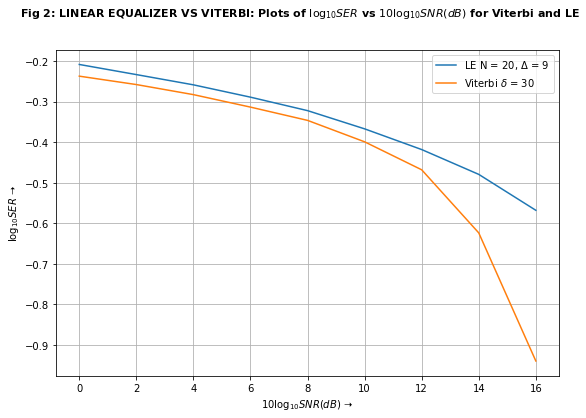

In [92]:
# Plotting log_10SER vs 10log_10SNR for Linear Equalizer vs Viterbi (delta=30)

fig, ax = plt.subplots(figsize = (9,6))
ax.plot(dB_SNR, log_SER_list_LE, 
        label = f"LE N = {N_best_LE}, $\Delta$ = {delta_best_LE}")
ax.plot(dB_SNR, SER_lists[30], label = f"Viterbi $\delta$ = {30}")
ax.legend()
ax.grid(True)
ax.set_xlabel("$10\log_{10}SNR (dB)$ \u279d")
ax.set_ylabel("$\log_{10}SER$ \u279d")
plt.suptitle("Fig 2: LINEAR EQUALIZER VS VITERBI: Plots of $\log_{10}SER$ vs $10\log_{10}SNR (dB)$ for Viterbi and LE", fontsize = 11, fontweight = "bold")
plt.show()

- We observe that the Linear Equalizer does worse than the Viterbi ($\delta = 30$) Algorithm for all values of SNR. 
- This is because the Linear Equalizer is a sub-optimal decoder algorithm that sacrifices performance for ease of practical implementation and cost. Even the running time of the simulation above is much faster for the Linear Equalizer than the Viterbi Algorithm. However, the SER is not as low.
- Finally, even with the Linear Equalizer, we observe that SER decreases quite rapidly as we increase SNR.

___________________________________________________________________

## **(c) Decision-Feedback Equalizer**

The Wiener solution to the Decision-Feedback Equalizer is _also_ given by:
\begin{align}
\mathbf{w_{opt}} & = \mathbf{R}^{-1}\cdot\mathbf{p}
\end{align} 
<br>
However, the effective matrix $\mathbf{R}$ and effective vector $\mathbf{p}$ are calculated differently.

The matrix $\mathbf{R}$ is calculated same as earlier, as:
\begin{align}
\mathbf{R} & = \mathbb{E}[\mathbf{r\cdot r^T}]
\end{align}
BUT the vector $\mathbf{r}$ is given by
\begin{align}
\mathbf{r}=
\begin{bmatrix}
r(k) & r(k-1) & \ldots & r(k-N_1+1) & -I(k-\Delta-1) & \ldots & -I(k-\Delta-N_2)
\end{bmatrix}^T
\end{align}

where $N1 = $ order of the feedforward filter, $N2 = $ order of the feedback filter.

If we denote
\begin{align}
\mathbf{r_1}=
\begin{bmatrix}
r(k) & r(k-1) & \ldots & r(k-N_1+1)
\end{bmatrix}^T
\end{align}

and
\begin{align}
\mathbf{r_2}=
\begin{bmatrix}
-I(k-\Delta-1) & \ldots & -I(k-\Delta-N_2)
\end{bmatrix}^T
\end{align}

then the matrix R will have 4 sub-matrices of the form:
\begin{align}
\mathbf{R} & = 
\begin{bmatrix}
\mathbf{R_1}_{N_1\times N_1} & \mathbf{R_2}_{N_1\times N_2} \\
\mathbf{R_2^T}_{N_2\times N_1} & \mathbf{R_4}_{N_2\times N_2}
\end{bmatrix} \\
\end{align}

where (assuming $\Delta=1$ for the sake of representation), 
\begin{align}
\mathbf{R_1} & = \mathbb{E}
\begin{bmatrix}
\mathbf{r_1}\cdot\mathbf{r_1}^T
\end{bmatrix} \\
& = \begin{bmatrix}
(f_0^2+f_1^2+f_2^2)\sigma_I^2 + \sigma_v^2 & (f_0f_1 + f_1f_2)\sigma_I^2 & \ldots & 0 \\
(f_0f_1 + f_1f_2)\sigma_I^2 & (f_0^2+f_1^2+f_2^2)\sigma_I^2 + \sigma_v^2 & \ldots & 0\\
\vdots & \vdots & \ldots & \vdots \\
0 &(f_0f_1 + f_1f_2)\sigma_I^2 & \ldots & (f_0^2+f_1^2+f_2^2)\sigma_I^2 + \sigma_v^2 \\
\end{bmatrix}_{N_1\times N_1}
\end{align}
<br>
\begin{align}
\mathbf{R_2} & = \mathbb{E}
\begin{bmatrix}
\mathbf{r_1}\cdot\mathbf{r_2}^T
\end{bmatrix} \\
& = \begin{bmatrix}
-f_2 \sigma_I^2 & 0 & 0 & \ldots & 0 \\
-f_1\sigma_I^2 & -f_2\sigma_I^2 & 0 & \ldots & 0\\
-f_0\sigma_I^2 & -f_1\sigma_I^2 & -f_2\sigma_I^2 & \ldots & 0\\
\vdots & \vdots & \vdots & \ldots & \vdots \\
0 & 0 & 0 & \ldots & 0 \\
\end{bmatrix}_{N_1\times N_2}
\end{align}
<br>
(The last row will be all zeros if $N_1 > N_2$ and $N_1-N_2 \geq L-1$.)
\begin{align}
\mathbf{R_4} & = \mathbb{E}
\begin{bmatrix}
\mathbf{r_2}\cdot\mathbf{r_2}^T
\end{bmatrix} \\
& = \begin{bmatrix}
-\sigma_I^2 & 0 & 0 & \ldots & 0 \\
0& \sigma_I^2 & 0 & \ldots & 0\\
0 & 0 & -\sigma_I^2 & \ldots & 0\\
\vdots & \vdots & \vdots & \ldots & \vdots \\
0 & 0 & 0 & \ldots & -\sigma_I^2 \\
\end{bmatrix}_{N_2\times N_2} \\
& = -\sigma_I^2\cdot \mathbf{I}_{N_2\times N_2}
\end{align}
<br>
Finally,
\begin{align}
\mathbf{R} & = 
\begin{bmatrix}
\mathbf{R_1}_{N_1\times N_1} & \mathbf{R_2}_{N_1\times N_2} \\
\mathbf{R_2^T}_{N_2\times N_1} & \mathbf{I}_{N_2\times N_2}
\end{bmatrix} \\
\end{align}
<br>

The change in the vector $\mathbf{r}$ will cause a change in the vector $\mathbf{p}$ as well.
\begin{align}
\mathbf{p} & = \mathbb{E}[\mathbf{r} \cdot I(k-\Delta)]
\end{align}
where $\Delta$ is the decoding delay.

We can split $\mathbf{p}$ as:
\begin{align}
\mathbf{p} & = 
\begin{bmatrix}
\mathbf{p_1} & \mathbf{p_2}
\end{bmatrix}^T
\end{align}

where (assuming $\Delta = 1$ for representation),
\begin{align}
\mathbf{p_1} & = \mathbb{E}[\mathbf{r_1} \cdot I(k-\Delta)] \\
 & = \mathbb{E}[\mathbf{r_1} \cdot I(k-1)] \\
 & =
\begin{bmatrix}
f_1 & f_0 & 0 & 0 & \ldots & 0
\end{bmatrix}^T_{N_1\times 1}
\end{align}

and
\begin{align}
\mathbf{p_2} & = \mathbb{E}[\mathbf{r_2} \cdot I(k-\Delta)]\\
& = \mathbb{E}
\begin{bmatrix}
(I(k-\Delta-1) \cdot I(k-\Delta)) & (I(k-\Delta-2)\cdot I(k-\Delta)) & \ldots & (I(k-\Delta-N_2) \cdot I(k-\Delta))
\end{bmatrix}^T \\
& = 
\begin{bmatrix}
0 & 0 & \ldots & 0
\end{bmatrix}^T_{N_2\times 1}
\end{align}

Finally,
\begin{align}
\mathbf{p} & = 
\begin{bmatrix}
\mathbf{p_1}_{(1\times N_1)} & \mathbf{0}_{(1\times N_2)}
\end{bmatrix}^T
\end{align}

__________________________________________________________

The minimum cost $J_{min}$ of the Wiener solution is still given by 
\begin{align}
J_{min} & = \sigma_I^2 + \mathbf{w_{opt}}^T\cdot \mathbf{p}
\end{align}

__________________________________________________________

The Decision-Feedback Equalizer is implemented in code below.

In [93]:
# Importing required packages

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.linalg import toeplitz

In [94]:
# Channel coefficients
f0 = 0.8/np.sqrt(2)
f1 = -1/np.sqrt(2)
f2 = 0.6/np.sqrt(2)
f = np.array([f0, f1, f2])

# Function to find Wiener solution of DFE
def DFE(SNR, L, N1, N2, delta):
    var_I = 1           # Signal variance
    var_v = 1/SNR       # Noise variance
    
    # Evaluating R and p for the DFE case
    # Splitting up R into R1, R2, R4 and p into p1, p2 helps
    R_col = []
    p1 = []

    R2 = []

    for j in range(N1):
        # R_col contains the first column of Toeplitz submatrix R1 
        R_col.append(np.matmul(np.hstack((f, np.zeros(j))), 
                               np.hstack((np.zeros(j), f)).T)*var_I)
        # p1 is the top portion of p
        if delta-j in range(0, L):
            p1.append(f[delta-j]*var_I)
        else:
            p1.append(0)

        # R2 submatrix is calculated here
        row = []
        for j1 in range(1, N2+1):
            if delta-j+j1 in range(0, L):
                row.append(-f[delta-j+j1]*var_I)
            else:
                row.append(0)
        R2.append(row)
        

    R2 = np.array(R2)
    R1 = toeplitz(R_col) + np.eye(N1)*var_v
    p1 = np.array(p1)[:, np.newaxis]

    # R4 is the N2*N2 identity matrix
    R4 = np.eye(N2)*var_I
    # p2 is an all-zero sub-vector
    p2 = np.zeros(N2)[:, np.newaxis]

    # Finally obtaining R and p
    R = np.vstack((np.hstack((R1, R2)), np.hstack((R2.T, R4))))
    p = np.vstack((p1, p2))

    np.set_printoptions(precision = 3, suppress = True)

    # Solving Rw = p for the Wiener solution
    w_opt = np.matmul(np.linalg.inv(R), p).flatten()

    # Calculating J_min for the obtained w_opt
    J_min = var_I - np.matmul(w_opt.T, p).flatten()[0]

    return w_opt, J_min

### (c1)

In [95]:
w_opt1, J_min1 = DFE(SNR = 10, L = 3, N1 = 6, N2 = 4, delta = 0)
print(f"DFE Wiener Solution for (N1=6, N2=4, Delta=0) is")
print(f"w_opt = {w_opt1},")
print(f"corresponding J_min = {J_min1}")

DFE Wiener Solution for (N1=6, N2=4, Delta=0) is
w_opt = [ 1.347  0.     0.     0.     0.     0.    -0.952  0.571  0.     0.   ],
corresponding J_min = 0.23809523809523814


### (c2)

In [96]:
w_opt2, J_min2 = DFE(SNR = 10, L = 3, N1 = 6, N2 = 4, delta = 3)
print(f"DFE Wiener Solution for (N1=6, N2=4, Delta=3) is")
print(f"w_opt = {w_opt2},")
print(f"corresponding J_min = {J_min2}")

DFE Wiener Solution for (N1=6, N2=4, Delta=3) is
w_opt = [ 0.061 -0.03  -0.366  1.016 -0.     0.    -0.873  0.431 -0.     0.   ],
corresponding J_min = 0.17957867415362583


### (c3)

N1 = 1, N2 = 9, delta = 0, J = 1.0
N1 = 2, N2 = 8, delta = 0, J = 0.725
N1 = 3, N2 = 7, delta = 0, J = 0.4221921148895815
N1 = 4, N2 = 6, delta = 0, J = 0.17957867415362583
N1 = 5, N2 = 5, delta = 0, J = 0.17957867415362583
N1 = 6, N2 = 4, delta = 0, J = 0.17957867415362583
N1 = 7, N2 = 3, delta = 0, J = 0.17957867415362594
N1 = 8, N2 = 2, delta = 0, J = 0.17957867415362583
N1 = 9, N2 = 1, delta = 0, J = 0.21933074265274455
N1 = 10, N2 = 0, delta = 0, J = 0.34505001949373315



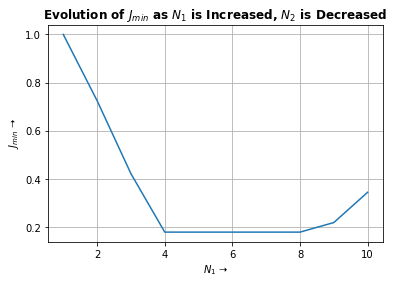


Best value of (N1, N2) = ( 8 , 2 )


In [108]:
# Finding best value of N1 (and hence, N2) for the DFE

N1_list_DFE = np.arange(10)+1
J_list_DFE = []

for N1_val in N1_list_DFE:
    _, J = DFE(SNR = 10, L = 3, N1 = N1_val, N2 = 10-N1_val, delta = 3)
    print(f"N1 = {N1_val}, N2 = {10-N1_val}, delta = 0, J =", J)
    J_list_DFE.append(J)

"""Within the roughly flat region of cost J, it is better to choose the
higher value of N because the slope dJ/dN is smaller there - lower chances
of rapid increase of J with variation in N"""

print()
plt.figure(figsize=(6,4))
plt.plot(N1_list_DFE, J_list_DFE)
plt.xlabel("$N_1$ \u279d")
plt.ylabel("$J_{min}$ \u279d")
plt.title("Evolution of $J_{min}$ as $N_1$ is Increased, $N_2$ is Decreased", fontweight = 'bold')
plt.grid(True)
plt.show()

# The highest value of N with the minimum value is selected
selected_N1_DFE = list(reversed(N1_list_DFE))[np.argmin(list(reversed(J_list_DFE)))]
print()
print("Best value of (N1, N2) = (", selected_N1_DFE,",", 
      10-selected_N1_DFE, ")")

N = 20, delta = 0, J = 0.23809523809523792
N = 20, delta = 1, J = 0.18551236749116606
N = 20, delta = 2, J = 0.18163147423143577
N = 20, delta = 3, J = 0.17957867415362583
N = 20, delta = 4, J = 0.17525336984847506
N = 20, delta = 5, J = 0.17387811102785555
N = 20, delta = 6, J = 0.17385976192922592
N = 20, delta = 7, J = 0.17372072544483863
N = 20, delta = 8, J = 0.39046321946382967
N = 20, delta = 9, J = 0.6878780584028079
N = 20, delta = 10, J = 1.0
N = 20, delta = 11, J = 1.0



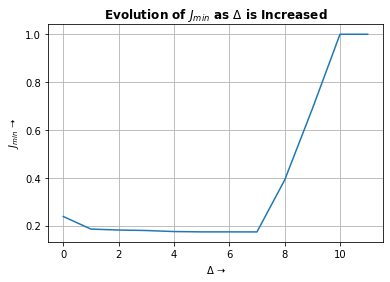


Best value of delta = 7 with a final best J_min value of 0.17372072544483863


In [109]:
# Finding best value of 'delta' for DFE and corresponding best J_min
delta_list_DFE = list(range(12))

J_list_DFE = []

for delta_val in delta_list_DFE:
    _, J = DFE(SNR = 10, L = 3, N1 = selected_N1_DFE, N2 = 10-selected_N1_DFE, 
               delta = delta_val)
    print(f"N = 20, delta = {delta_val}, J =", J)
    J_list_DFE.append(J)

print()
plt.figure(figsize=(6,4))
plt.plot(delta_list_DFE, J_list_DFE)
plt.xlabel("$\Delta$ \u279d")
plt.ylabel("$J_{min}$ \u279d")
plt.title("Evolution of $J_{min}$ as $\Delta$ is Increased", fontweight = 'bold')
plt.grid(True)
plt.show()

selected_delta_DFE = delta_list_DFE[np.argmin(J_list_DFE)]
print()
print("Best value of delta =", selected_delta_DFE, 
      "with a final best J_min value of", min(J_list_DFE))

In [110]:
# Storing best N1, delta, and calculating best w_opt for DFE

N1_best_DFE = selected_N1_DFE
delta_best_DFE = selected_delta_DFE

w_opt_best_DFE, J_min_best_DFE = DFE(SNR = 10, L = 3, N1 = N1_best_DFE, 
                                N2 = 10-N1_best_DFE, delta = delta_best_DFE)

# Printing best N1, N2, Delta, J_min

print("Final best values of N1, N2, Delta, J_min:")
print("N1 =", N1_best_DFE)
print("N2 =", 10-N1_best_DFE)
print("Delta =", delta_best_DFE)
print("J_min =", J_min_best_DFE)

Final best values of N1, N2, Delta, J_min:
N1 = 8
N2 = 2
Delta = 7
J_min = 0.17372072544483863


### (c4)

In [111]:
# Simulating DFE to evaluate SER and plot it

def simulateDFE(SNR, Ik, N1, delta):
    var_I = 1           # Signal variance
    var_v = var_I/SNR   # Noise variance

    L = 3           # Channel length

    # Calculating w_opt and J_min for given N1, N2, delta
    w_, J_ = DFE(SNR = SNR, L = 3, N1 = N1,  N2 = 10 - N1, delta = delta)

    # Splitting up w_opt into w_ff and w_fb for DFe
    w_ff = w_[:N1]
    w_fb = w_[N1:]

    # Initialising channel, w_ff, w_fb values
    channel = np.ones(L)*-1*d
    wff_vals = np.ones(len(w_ff))*0*d
    wfb_vals = np.ones(len(w_fb))*0*d

    # Stores decoded sequence
    decoded_seq = []

    # Iterating through input sequence except "tail" symbols
    for ind, i in enumerate(Ik[:-2]):
        # Pushing symbol into channel
        for j in range(L-1,0,-1):
            channel[j] = channel[j-1]
        channel[0] = i

        # Calculating r(k) through convolution with channel + adding noise
        yk = np.matmul(f, channel.T)
        vk = np.random.normal()*np.sqrt(var_v)
        rk = yk + vk

        # Pushing r(k) into w_ff feed-forward filter
        for j in range(len(wff_vals)-1, 0, -1):
            wff_vals[j] = wff_vals[j-1]
        wff_vals[0] = rk

        # Calculating feed-forward output
        f_op = np.matmul(w_ff, wff_vals.T)

        # Pushing delayed symbol into w_fb feedback filter
        for j in range(len(wfb_vals)-1, 0, -1):
            wfb_vals[j] = wfb_vals[j-1]
        if ind > 0:
            wfb_vals[0] = decoded_seq[ind-1]
        # Calculating feedback output
        b_op = np.matmul(w_fb, wfb_vals.T)

        # Calculating FINAL equalizer output
        eq_op = f_op - b_op

        # Predicting symbol - assigning least distant symbol to output
        pred_symb = 0
        if eq_op < -2*d:
            pred_symb = -3*d
        elif eq_op < 0:
            pred_symb = -d
        elif eq_op < 2*d:
            pred_symb = d
        else:
            pred_symb = 3*d
        
        # Appending decoded symbol to sequence
        decoded_seq.append(pred_symb)

    # Truncating the last 'delta' symbols of I(k) and first 'delta'
    # symbols of decoded sequence, similar to LE case
    if delta == 0:
        Ik_valid = Ik[:-2]
    else:
        Ik_valid = Ik[:-2][:-delta]

    return Ik_valid, decoded_seq[delta:]


In [112]:
# SNR values s.t. 10log(SNR) = 0, 2, 4, 6, 8, 10, 12, 14, 16 dB as required
SNR_list = np.logspace(0, 1.6, 9, base = 10)
dB_SNR = 10*np.log10(SNR_list)

# Evaluating SER for DFE and storing in a list for plotting
log_SER_list_DFE = []
for snr in SNR_list:
    Ik_valid, decoded_seq = simulateDFE(SNR = snr, Ik=Ik, N1 = N1_best_DFE, 
                                        delta = delta_best_DFE)
    SER = 1 - np.sum(Ik_valid == decoded_seq)/len(Ik_valid)
    log_SER = np.log10(SER)
    log_SER_list_DFE.append(log_SER)
    print("SNR =", 10*np.log10(snr), " dB done...")

SNR = 0.0  dB done...
SNR = 2.0000000000000004  dB done...
SNR = 4.0  dB done...
SNR = 6.000000000000001  dB done...
SNR = 8.0  dB done...
SNR = 10.0  dB done...
SNR = 12.000000000000002  dB done...
SNR = 14.000000000000002  dB done...
SNR = 16.0  dB done...


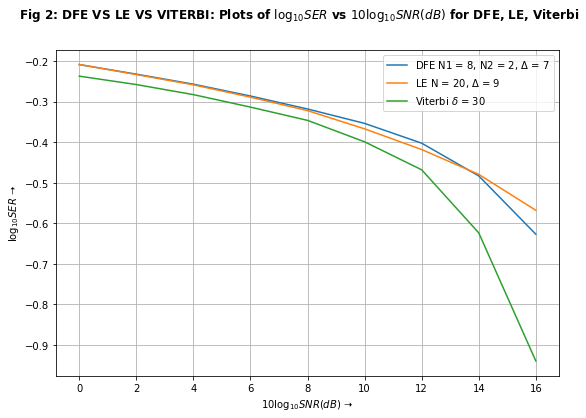

In [119]:
# Plotting log_10SER vs 10log_10SNR for DFE vs LE and Viterbi (delta=30)

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(dB_SNR, log_SER_list_DFE, 
        label = f"DFE N1 = {N1_best_DFE}, N2 = {10-N1_best_DFE}, $\Delta$ = {delta_best_DFE}")
ax.plot(dB_SNR, log_SER_list_LE, 
        label = f"LE N = {N_best_LE}, $\Delta$ = {delta_best_LE}")
ax.plot(dB_SNR, SER_lists[30], label = f"Viterbi $\delta$ = {30}")
ax.legend()
ax.grid(True)
ax.set_xlabel("$10\log_{10}SNR (dB)$ \u279d")
ax.set_ylabel("$\log_{10}SER$ \u279d")
plt.suptitle("Fig 2: DFE VS LE VS VITERBI: Plots of $\log_{10}SER$ vs $10\log_{10}SNR (dB)$ for DFE, LE, Viterbi", fontsize = 12, fontweight = "bold")
plt.show()

- We observe that the DFE still does worse than the Viterbi ($\delta = 30$) Algorithm for all values of SNR - it is still a sub-optimal algorithm. 
- However, it makes use of feedback to do better than the Linear Equalizer. The SER drops more rapidly than the Linear Equalizer as we increase SNR. The reason that it does worse than the Linear Equalizer at lower SNRs, is perhaps because at lower SNR (high noise), the DFE is more prone to the error-propagation problem that it comes with.
- Finally, the decrease of SER with increasing SNR continues to be a trait of this algorithm as well.

___________________________________________________________________

## **Bonus Question**

- Since both the LE and DFE are equalizers, we expect that they return the best possible estimation of the original transmitted symbol.
- This means that the "effective" overall impulse response of the channel + equalizer is ideally close to the impulse itself, i.e., the Dirac delta function. This impulse may however by delayed, since the bits may be decoded with some delay.
- The residual ISI terms show up as extra terms (before and after the Dirac delta function) in the effective impulse response. This means that each symbol is getting smeared by the symbols next to it by a small amount (which is what ISI is).

- Therefore, the variance of the residual ISI terms is given by:
\begin{align}
\sigma_{ISI}^2 = \sum_n h_{eff}^2[n] - h_{eff}^2[n_{max}]
\end{align}
where $h_{eff}$ is the effective impulse response, with n coefficients. $n_{max}$ refers to the position of the largest coefficient - it would correspond to the expected Dirac delta in the impulse response (the cursor position).

**For the Linear Equalizer:**

- The effective impulse response is given by:
\begin{align}
h_{eff} = f \ast w_{opt}
\end{align}
since the output is obtained after the input simply passes through the channel and then the linear equalizer one after the other.
- We use this to obtain $h_{eff}$, plot its coefficients to observe the presence of a rough, delayed Dirac delta function, and then compute the variance of the residual ISI in the code below.

<br><br><br><br><br><br><br><br><br><br><br>{CODE BELOW}<br><br><br><br><br><br><br><br><br><br><br>

In [114]:
# Importing required packages

import numpy as np
import matplotlib.pyplot as plt

N = 20, delta = 0, J = 0.44470802028801537
N = 20, delta = 1, J = 0.3593133164979284
N = 20, delta = 2, J = 0.3594297628876384
N = 20, delta = 3, J = 0.34505001949373315
N = 20, delta = 4, J = 0.33523140612210733
N = 20, delta = 5, J = 0.33687413740034433
N = 20, delta = 6, J = 0.33848753609074655
N = 20, delta = 7, J = 0.34032125026374294
N = 20, delta = 8, J = 0.38054053107252117
N = 20, delta = 9, J = 0.46770448279142796
N = 20, delta = 10, J = 0.4832187772823374
N = 20, delta = 11, J = 0.6876482614120087

Best value of delta = 4 with a final best J value of 0.33523140612210733



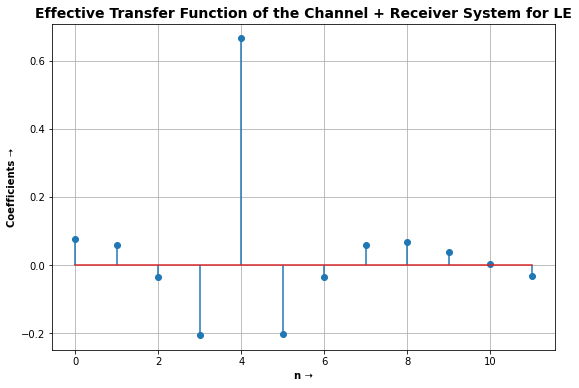

In [115]:
# LINEAR EQUALIZER PART

"""We need to calculate a new best Linear Equalizer for the 10-tap condition
provided."""

delta_list_LE10 = list(range(12))
J_list_LE10 = []

# Fixing N = 10 and calculating best 'delta'
for delta_val in delta_list_LE10:
    _, J = linearEq(SNR = 10, L = 3, N = 10, delta = delta_val)
    print(f"N = 20, delta = {delta_val}, J =", J)
    J_list_LE10.append(J)

delta_best_LE10 = delta_list_LE10[np.argmin(J_list_LE10)]
print()
print("Best value of delta =", delta_best_LE10, "with a final best J value of", 
                                                            min(J_list_LE10))
print()

# Calculating best 10-tap w_opt
w_opt_best_LE10, J_min_best_LE10 = linearEq(SNR = 10, L = 3, N = 10, 
                                            delta = delta_best_LE10)

"""Effective impulse response function for LE = f * w_opt. We expect that the 
equalizer should be as close to a delayed delta function (impulse) as possible."""
effective_fn_LE = np.convolve(f, w_opt_best_LE10)

# Plotting the effective impulse response to get an idea of ISI
# Comparing it to the delta function

plt.figure(figsize=(9,6))
plt.stem(effective_fn_LE, use_line_collection=True)
plt.grid(True)
plt.title("Effective Transfer Function of the Channel + Receiver System for LE", 
          fontsize = 14, fontweight = 'bold')
plt.ylabel('Coefficients \u279d', fontweight = 'bold')
plt.xlabel('n \u279d', fontweight = 'bold')
plt.show()

In [116]:
"""Now, we take the variance of all ISI terms, i.e., the sum of squares
of taps other than the maximum/dominant tap which is the expected Dirac delta"""

var_ISI_LE = np.sum(effective_fn_LE**2) - np.max(effective_fn_LE)**2
print("The variance of residual ISI terms for best LE =", var_ISI_LE)

The variance of residual ISI terms for best LE = 0.10599230999197018


**For the Decision-Feedback Equalizer:**

- The effective impulse response is given by:
\begin{align}
h_{eff} = f \ast w_{ff} - z^{-(\Delta+1)} \ast w_{fb}
\end{align}
- The output is obtained after the input passes through the feedforward filter (which removes pre-cursor ISI) and gets subtracted by the delayed impulse response of the feedback filter (delayed by $\Delta + 1$) which removes the post-cursor ISI.
- We use this to obtain $h_{eff}$, plot the intermediate coefficients to observe and verify the action of pre-cursor and post-cursor ISI, and then compute the variance of the residual ISI in the code below.

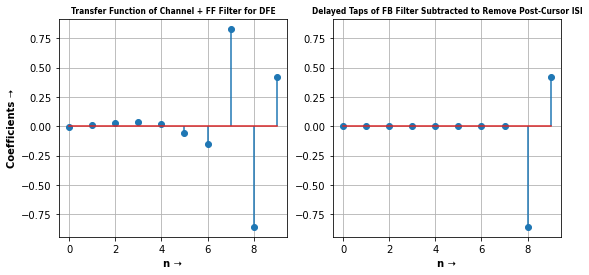

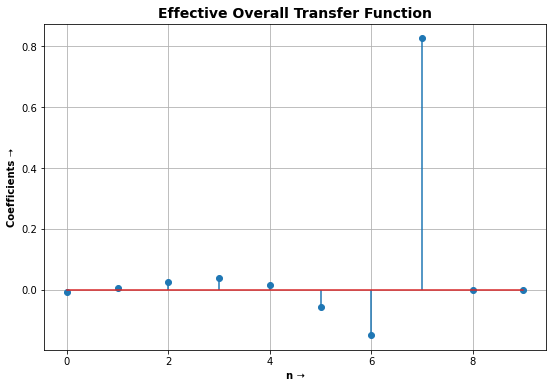

In [120]:
# DECISION-FEEDBACK EQUALIZER PART

"""In the decision-feedback equalizer, the feedforward filter only takes care of
pre-cursor ISI, where the cursor position indicates the Dirac delta's position.
The delayed impulse response through the feedback filter takes care of the
post-cursor ISI. This is subtracted from the feedforward impulse response to 
obtain effective impulse response of DFE, with removed post-cursor ISI."""

# We can use previously calculated w_opt as N1+N2=N=10 was maintained earlier.
w_ff_best_DFE = w_opt_best_DFE[:N1_best_DFE]

# Feedforward impulse response is calculated and plotted.
# We observe low pre-cursor and high post-cursor ISI as expected.
forward_fn_DFE = np.convolve(f, w_ff_best_DFE)

fig1, ax1 = plt.subplots(1, 2, figsize = (9, 4))
ax1[0].stem(forward_fn_DFE, use_line_collection=True)
ax1[0].grid(True)
ax1[0].set_title("Transfer Function of Channel + FF Filter for DFE",
                 fontsize = 7.5, fontweight = 'bold')
ax1[0].set_ylabel('Coefficients \u279d', fontweight = 'bold')
ax1[0].set_xlabel('n \u279d', fontweight = 'bold')

# Delayed feedback impulse response is calculated and plotted.
# We observe terms post the cursor position that can cancel out ISI.
w_fb_best_DFE = w_opt_best_DFE[N1_best_DFE:]
delayed_wfb = np.concatenate((np.zeros(delta_best_DFE+1), w_fb_best_DFE))

plt.setp(ax1, ylim=ax1[0].get_ylim())
ax1[1].stem(delayed_wfb, use_line_collection=True)
ax1[1].grid(True)
ax1[1].set_title("Delayed Taps of FB Filter Subtracted to Remove Post-Cursor ISI", 
                 fontsize = 7.5, fontweight = 'bold')
ax1[1].set_xlabel('n \u279d', fontweight = 'bold')
plt.show()

# We subtract feedback output from feedforward output to obtain effective 
# impulse response.
effective_fn_DFE = forward_fn_DFE - delayed_wfb

# Upon plotting the taps, we observe low ISI overall as expected.
fig2, ax2 = plt.subplots(figsize = (9, 6))
ax2.stem(effective_fn_DFE, use_line_collection=True)
ax2.grid(True)
ax2.set_title("Effective Overall Transfer Function", fontsize = 14, 
              fontweight = 'bold')
ax2.set_ylabel('Coefficients \u279d', fontweight = 'bold')
ax2.set_xlabel('n \u279d', fontweight = 'bold')
plt.show()

In [118]:
"""Again, the variance of all ISI terms = the sum of squares of taps other 
than the maximum/dominant tap which is the expected Dirac delta (impulse)"""

var_ISI_DFE = np.sum(effective_fn_DFE**2) - np.max(effective_fn_DFE)**2
print("The variance of residual ISI terms for best DFE =", var_ISI_DFE)

The variance of residual ISI terms for best DFE = 0.02776444708536796


- We observe that the variance of residual ISI is significantly smaller in the DFE as compared to the LE.
_________________________________________________________________________________________